# Automatically scrape job postings of a competitor

We will now see scraping in action. Imagine you are working in HR for a major retailer. Your boss asks you to monitor the strategic hiring decisions of your close competitors. Naturally, you cannot go and call them up - but you could take a look at their job postings to see ($i$) how much they are hiring, ($ii$) what types of positions they are hiring for.

Now, you could log onto their website every day, see what job postings there are, compare that with the job postings from before, and save the relevant data. But why go through so much effort if we can just automate the task?

## 1. Using BeautifulSoup

The first example relies purely on what we have learned about BeautifulSoup and Requests (and a bit of Pandas!).

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

We are searching for positions in the head office of Aldi. On the website, we see that there are different types of head office positions, each with their own website. Let's get the links to those sub-sites.

In [2]:
url = "https://www.aldirecruitment.co.uk/head-office"
page = requests.get(url)
soup = BeautifulSoup(page.content, "html.parser")
print(soup)

<!DOCTYPE html>

<html lang="en">
<head>
<meta charset="utf-8"/>
<meta content="IE=edge,chrome=1,IE=8" http-equiv="X-UA-Compatible"/>
<meta content="width=device-width, initial-scale=1, maximum-scale=1, user-scalable=no" name="viewport"/>
<meta content="yes" name="mobile-web-app-capable"/>
<style>html{visibility: hidden;opacity:0;}</style>
<link as="style" href="/dist/css/screen.css?v=5" rel="preload"/>
<link as="script" href="/dist/js/commons.js?v=5" rel="preload"/>
<link as="script" href="/dist/js/main.js?v=5" rel="preload"/>
<link href="https://cc.cdn.civiccomputing.com" rel="preconnect">
<link href="https://apikeys.civiccomputing.com" rel="preconnect">
<link href="https://www.google-analytics.com" rel="preconnect">
<link href="https://www.googletagmanager.com" rel="preconnect"/>
<link href="/dist/css/screen.css?v=5" rel="stylesheet" type="text/css"/>
<title>Head Office | Aldi Recruitment UK</title>
<meta content="en_GB" property="og:locale">
<meta content="website" property="og:typ

In [3]:
links = []
for link in soup.findAll('a'):
    links.append(link.get('href'))
print(links)

[None, '/', None, '/', '/about-us/', '/stores/', '/stores/', '/stores/store-manager/', '/stores/assistant-store-manager/', '/stores/deputy-store-manager/', '/stores/store-assistant/', '/stores/stock-assistant/', '/stores/caretaker-cleaner/', '/head-office/', '/warehouse-transport/', '/area-manager-programme/', '/area-manager-programme/', '/area-manager-programme/graduate-area-manager-programme/', '/area-manager-programme/career-changers/', '/placement-programmes/', '/apprenticeships/', '/contact-us/#contact-us', '/about-us/#equality-and-diversity', '/about-us/#right-to-work', 'https://www.aldi.co.uk/', '/privacy-notice-cookies/', 'https://www.facebook.com/AldiCareersUK', 'https://www.youtube.com/user/AldiUK', 'https://twitter.com/AldiCareersUK', 'https://www.linkedin.com/company/aldi-uk', 'https://www.instagram.com/aldiCareersuk', '/job-search/', '/', '/job-search/', '/job-search/', '/job-search/', '/head-office/national-administration/', '/head-office/regional-administration/', '/head

We want to get only the links to actual job postings, so we have to clean the results somewhat:

In [4]:
cleaned_links = []
for link in links:
    if link != None and link != '/head-office/' and link.startswith('/head-office/'):
        cleaned_links.append(link.replace('/head-office',''))
links = cleaned_links
print(links)

['/national-administration/', '/regional-administration/', '/national-buying/', '/corporate-responsibility/', '/customer-service/', '/ecommerce/', '/global-business-coordination/', '/hr/', '/it/', '/marketing-communications/', '/merchandising-category/', '/national-property/', '/supply-chain-management/', '/quality-assurance/', '/quality-control/']


Let's see how many postings there are on one of the sub-sites. For this, we have to find the right tags, using their class argument. Again, inspecting the site is very important!

In [5]:
url + links[0]

'https://www.aldirecruitment.co.uk/head-office/national-administration/'

In [6]:
category_url = url + links[0]
page = requests.get(category_url)
soup = BeautifulSoup(page.content, "html.parser")
postings = soup.findAll("div", class_="c-career--dropdown")
len(postings)

14

We now extract some information from the actual position: the job title.

In [7]:
title = postings[0].find("div", class_="c-career--dropdown__content").find('h2')
print(title.text)

National Finance & Administration Manager


Aside from the title and the text description (which we will ignore in this example, but which can hold extremely useful information), there are some key details about the job, such as the work time and the salary.

In [8]:
details = postings[0].findAll("div", class_="c-job-details__content")
print(details)

[<div class="c-job-details__content">
<img data-replace="false" src="/media/xjpjb1m0/market.svg" width="56">
<div>
<span class="c-job-details__title">Salary</span>
<div class="c-job-details__text"><p>£54,285 rising in increments to £79,040 in year 4.</p></div>
</div>
</img></div>, <div class="c-job-details__content">
<img data-replace="false" src="/media/ygxa0wif/island.svg" width="56"/>
<div>
<span class="c-job-details__title">Holiday allowance</span>
<div class="c-job-details__text"><p>5 weeks’ annual leave plus Bank Holidays.</p></div>
</div>
</div>, <div class="c-job-details__content">
<img data-replace="false" src="/media/e4pnj4sn/health.svg" width="56"/>
<div>
<span class="c-job-details__title">Hours and benefits</span>
<div class="c-job-details__text"><p>You’ll work a 50-hour week, working from Monday – Friday. Plus, you’ll receive a company pension when you start, private employee medical insurance after 6 months, company maternity and adoption leave from commencement as well a

We definitely want to get the salary information. Sometime, the text gives multiple values, so let's make sure to save the lowest and the highest value (of course, multiple values may be due to changes over time or for different starting requirements - we can adapt our scraper to capture arbitrary complexity later on).

In [9]:
detail = details[0]
detail_text = detail.find('div', class_="c-job-details__text").text
print(detail_text)

£54,285 rising in increments to £79,040 in year 4.


In [10]:
temp = detail_text.replace(',','')
temp = temp.replace('-','')
temp = temp.split()
salary_numbers = [float(s[1:]) for s in temp if s.startswith('£')]
ub = max(salary_numbers)
lb = min(salary_numbers)
print(ub)
print(lb)

79040.0
54285.0


Let's also try to capture the weekly working hours:

In [11]:
detail = details[2]
detail_text = detail.find('div', class_="c-job-details__text").text
for s in detail_text.split():
    if '-hour' in s:
        work_time = s
        work_time = int(work_time.replace('-hour',''))
print(work_time)

50


The following code combines our extraction of job details:

In [12]:
details = postings[0].findAll("div", class_="c-job-details__content")
for detail in details:
    detail_title = detail.find('span', class_="c-job-details__title").text
    detail_text = detail.find('div', class_="c-job-details__text").text
    if detail_title == 'Salary':
        temp = detail_text.replace(',','')
        temp = temp.replace('-','')
        temp = temp.split()
        salary_numbers = [float(s[1:]) for s in temp if s.startswith('£')]
        ub = max(salary_numbers)
        lb = min(salary_numbers)
    elif detail_title == 'Hours and benefits':
        for s in detail_text.split():
            if '-hour' in s:
                work_time = s
                work_time = int(work_time.replace('-hour',''))
print(ub)
print(lb)
print(work_time)

79040.0
54285.0
50


Finally, we are putting it all together into a simple-to-call function that returns a data frame of job postings. We have to make a few adjustments to avoid errors. These are marked with comments.

In [13]:
def scrape_aldi_jobs(starting_page = 'head-office'):
    url = "https://www.aldirecruitment.co.uk/" + starting_page
    page = requests.get(url)
    soup = BeautifulSoup(page.content, "html.parser")
    links = []
    for link in soup.findAll('a'):
        new_link = link.get('href')
        if new_link != None and new_link.startswith('/head-office/'):
            new_link = new_link.replace('/head-office','')
            if new_link != '/':
                links.append(new_link)
    
    department = []
    titles = []
    ubs = []
    lbs = []
    hours = []
    for link in links:
        category_url = url + link
        page = requests.get(category_url)
        soup = BeautifulSoup(page.content, "html.parser")
        postings = soup.findAll("div", class_="c-career--dropdown")
        for posting in postings:
            ## Also grabbing the department information
            dep_name = link.replace('-',' ').replace('/','')
            department.append(dep_name)
            titles.append(posting.find("div", class_="c-career--dropdown__content").find('h2').text)
            details = posting.findAll("div", class_="c-job-details__content")
            for detail in details:
                detail_title = detail.find('span', class_="c-job-details__title").text
                detail_text = detail.find('div', class_="c-job-details__text").text
                if detail_title == 'Salary':
                    temp = detail_text.replace(',','')
                    temp = temp.replace('-','')
                    temp = temp.split()
                    salary_numbers = [float(s[1:]) for s in temp if s.startswith('£')]
                    ## Salary may not be specified
                    if len(salary_numbers) > 0:
                        ## Salaries are sometimes specified as per week instead of per year
                        if 'per' in temp and 'week' in temp:
                            salary_numbers = [salary*52 for salary in salary_numbers]
                        ubs.append(max(salary_numbers))
                        lbs.append(min(salary_numbers))
                    else:
                        ubs.append(None)
                        lbs.append(None)
                ## Some postings say "Benefits" instead of "Hours and benefits", and sometimes the spelling is capitalized differently
                elif detail_title.lower() == 'hours and benefits' or detail_title.lower() == 'benefits':
                    ## Some postings do not specify a number of hours per week
                    work_time = None
                    for s in detail_text.split():
                        if '-hour' in s:
                            work_time = s
                            ## Some postings write, e.g., 40-hour per week, some 40-hours per week
                            if '-hours' in s:
                                work_time = int(work_time.replace('-hours',''))
                            else:
                                work_time = int(work_time.replace('-hour',''))
                    hours.append(work_time)
                        
    job_data = pd.DataFrame(
        {'Department': department,
         'Job title': titles,
         'Salary lower': lbs,
         'Salary upper': ubs,
         'Weekly hours': hours
        })
    return job_data

Let's try it out:

In [14]:
aldi_job_data = scrape_aldi_jobs()
aldi_job_data.head()

,Department,Job title,Salary lower,Salary upper,Weekly hours
0,national administration,National Finance & Administration Manager,54285.0,79040.0,50.0
1,national administration,National Tax Manager,44660.0,93655.0,50.0
2,national administration,Data Scientist,57.0,74430.0,40.0
3,national administration,National Finance & Administration Team Leader,47100.0,54255.0,40.0
4,national administration,Technical Analyst,47100.0,54255.0,40.0


We can now explore the data frame, improve our code if we find issues, and then analyze it. For example, let's have a look at a simple histogram of postings per department.

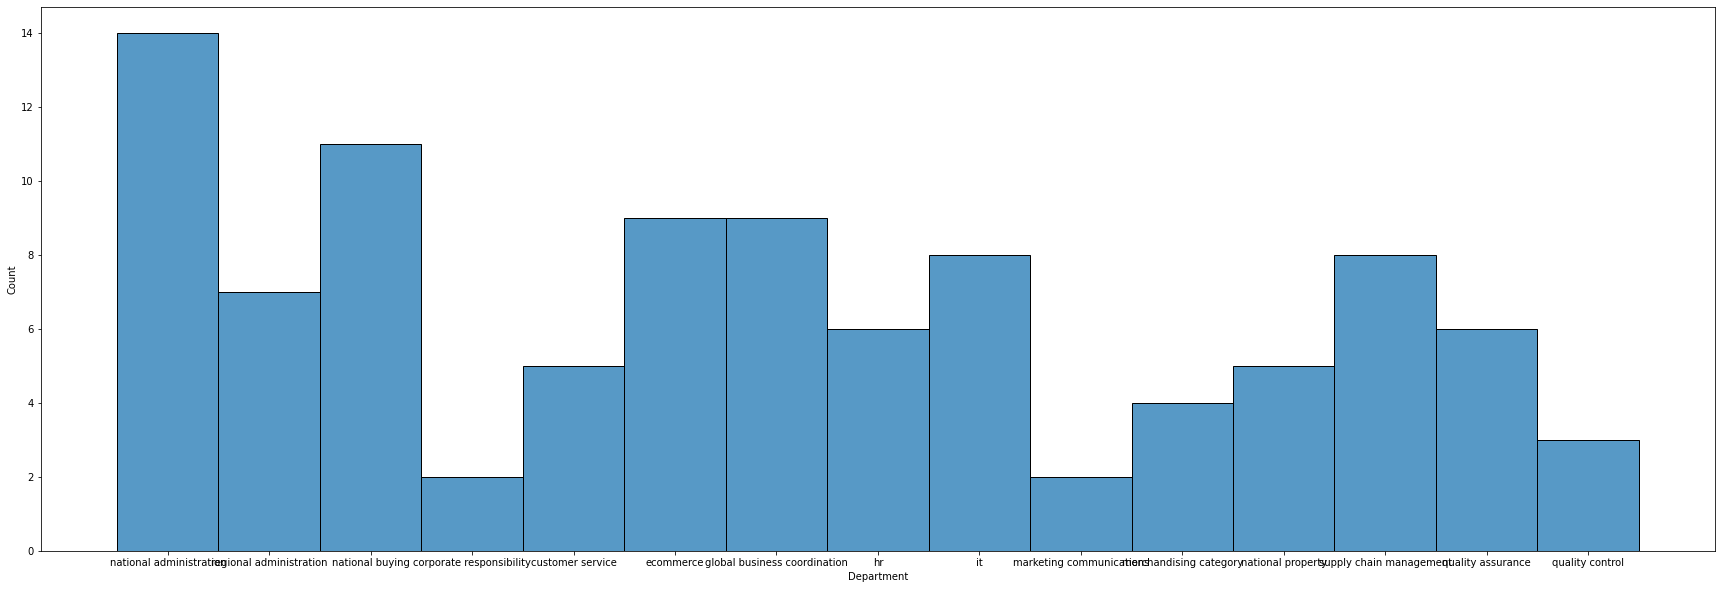

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(30, 10)
sns.histplot(data=aldi_job_data, x="Department",ax=ax)
plt.show()

Finally, save the job postings we found as a CSV:

In [ ]:
aldi_job_data.to_csv('Aldi_postings_2021-10-20.csv', index=False)

## 2. A more advanced case - using Selenium to enter details

Let's get data from a second competitor. We will use Lidle here (I am, of course, not biased in my choices). Check out Lidl's hiring page https://careers.lidl.co.uk/ and start a search. Then look at the link where you landed at - can you see why things are a bit more complex here?

Since we cannot just find the right links, we need to act like a browser. This is where Selenium comes in - it will literally run a browser!

In [16]:
import requests
from bs4 import BeautifulSoup
import selenium
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.keys import Keys
import pandas as pd
import re
import time

import chromedriver_autoinstaller
chromedriver_autoinstaller.install()

'/opt/anaconda3/envs/smm750/lib/python3.7/site-packages/chromedriver_autoinstaller/94/chromedriver'

In [17]:
def web_driver(headless=False):
    option = webdriver.ChromeOptions()
    if(headless == True):
        option.add_argument('--headless')
    # ua = UserAgent()
    # userAgent = ua.random
    # logger.info(userAgent)
    # option.add_argument(f'user-agent={userAgent}')
    option.add_argument(' — incognito')
    option.add_argument('start-maximized')
    option.add_argument('disable-infobars')
    option.add_argument('--disable-extensions')
    driver = webdriver.Chrome(options=option)
    return driver

We need to choose the type of browser that Selenium runs - and each comes with its own access and installation requirements. I personally recommend using Chrome. However, to use Chrome, with Selenium, you need to install ChromeDriver. The site https://sites.google.com/chromium.org/driver/downloads gives download files, which should work fine for Windows users. Simply download and unpack the Zip, which gives you a .exe file. Either move it somewhere on your PATH, or add it to your path (https://stackoverflow.com/questions/4822400/register-an-exe-so-you-can-run-it-from-any-command-line-in-windows gives a good description how to).

On Mac, you may run into access issues. The easiest way to proceed is to use Homebrew (https://brew.sh/ shows how to use it). Once done, type
```
brew install chromedriver
```
into your terminal.
Other options can be found here: https://www.kenst.com/2015/03/installing-chromedriver-on-mac-osx/ (note that the syntax can be a bit outdated).

Once done, the below code will open a new window in the browser of your choice (here Chrome):

In [74]:
# driver = webdriver.Chrome()
driver = web_driver()
driver.get("https://careers.lidl.co.uk/jobsearch")

You will notice that this is a completely new Chrome process - so cookies are not yet accepted. To see what's going on, let's start by accepting cookies. How do we do this? We simply find the right button (by insepcting the site, then copying the XPath), and then let Selenium click this button!

In [75]:
cookie_button = driver.find_element_by_xpath('//button[@class="cookie-alert-extended-button"]')
cookie_button.click()

The Lidl jobs site offers the option to select head office positions, just like Aldi. However, the link is relatively complex, so we will simply let Selenium click on the right button again.

In [76]:
head_office_button = driver.find_element_by_xpath('//h4[contains(text(),"Head Office Roles")]')
head_office_button.click()

There are a few positions here. If you click on any of those, you'll notice that the links are relatively simple in structure and don't depend on your website interaction. Hence, the easiest is for us to collect all the posting links

In [77]:
posting_urls = []
postings = driver.find_elements_by_xpath('//a[@class="jobResult"]')
for posting in postings:
    posting_urls.append(posting.get_attribute('href'))
print(posting_urls)

['https://careers.lidl.co.uk/jobs/warehouse-construction-consultant-gb-068715', 'https://careers.lidl.co.uk/jobs/fresh-produce-buying-administrator-ordering-and-promotions-team-gb-069480', 'https://careers.lidl.co.uk/jobs/food-promotions-administrator-german-speaking-gb-069499', 'https://careers.lidl.co.uk/jobs/reporting-and-planning-manager-german-speaking-gb-069497', 'https://careers.lidl.co.uk/jobs/buying-graduate-management-programme-gb-069631', 'https://careers.lidl.co.uk/jobs/construction-consultant-architectural-and-structural-gb-069994', 'https://careers.lidl.co.uk/jobs/it-office-management-administrator-gb-068873', 'https://careers.lidl.co.uk/jobs/construction-consultant-architectural-and-structural-gb-068855', 'https://careers.lidl.co.uk/jobs/it-service-management-administrator-gb-069128', 'https://careers.lidl.co.uk/jobs/fresh-produce-buying-administrator-gb-068998', 'https://careers.lidl.co.uk/jobs/crm-operations-executive-gb-069541', 'https://careers.lidl.co.uk/jobs/corpor

It may be that postings are spread across multiple pages (delete the filters to see this). Luckily, there is a forward button that let's us scroll through the pages. We can easily combine this with our previous code. Note that we only move forward if the next page element actually exists.
There can be a problem with identifying the button location. Usually, this can be fixed by maximizing the window in which Selenium runs.


Also, we add an implict wait so that the server has time to respond before our clicks.

In [78]:
stop = False
posting_urls = []
while not stop:
    driver.implicitly_wait(5)
    postings = driver.find_elements_by_xpath('//a[contains(@class,"jobResult")]')
    print("Found " + str(len(postings)) + " postings")
    for posting in postings:
        posting_urls.append(posting.get_attribute('href'))
    # next_elements = driver.find_elements_by_class_name('paginationArrow_next')
    next_elements = driver.find_elements_by_xpath('//button[contains(@class,"paginationArrow_next")]')
    
    if len(next_elements) > 0:
        element = driver.find_element_by_class_name('paginationArrow_next')
        if element.is_enabled():
            
            # The executeScript() method from the JavascriptExecutor Interface 
            # can invoke multiple arguments in the form of arguments[0], arguments[1], etc
            # arguments[0] below = element
            driver.execute_script("arguments[0].click();", element)
            time.sleep(3)
        else:
            stop = True
    else:
        stop = True

Found 15 postings
Found 10 postings


In [79]:
lidl_job_data = pd.DataFrame({'url': posting_urls})
lidl_job_data
# lidl_job_data.to_csv('Lidl_postings_2021-10-20.csv', index=False)

,url
0,https://careers.lidl.co.uk/jobs/warehouse-cons...
1,https://careers.lidl.co.uk/jobs/fresh-produce-...
2,https://careers.lidl.co.uk/jobs/food-promotion...
3,https://careers.lidl.co.uk/jobs/reporting-and-...
4,https://careers.lidl.co.uk/jobs/buying-graduat...
5,https://careers.lidl.co.uk/jobs/construction-c...
6,https://careers.lidl.co.uk/jobs/it-office-mana...
7,https://careers.lidl.co.uk/jobs/construction-c...
8,https://careers.lidl.co.uk/jobs/it-service-man...
9,https://careers.lidl.co.uk/jobs/fresh-produce-...


## Exercise 1

Now that we have loaded the urls of the relevant vacancies, can you extract key information (e.g., title and postcode of location, maybe also salary)? You might want to take a look at what we did for the Aldi vacancies.

If you are having problems running Selenium, you can use the uploaded list of urls (note: some may no longer be working):

In [ ]:
# posting_urls = pd.read_csv('Lidl_postings_2021-10-20.csv')['url'].tolist()

In [115]:
def scrape_lidl_jobs():
    title=[]; salary=[]; postcode=[]; contract=[]; bis_area=[]

    driver = web_driver()
    driver.get("https://careers.lidl.co.uk/jobsearch")
    driver.implicitly_wait(3)
    cookie_button = driver.find_element_by_xpath('//button[@class="cookie-alert-extended-button"]')
    cookie_button.click()
    time.sleep(1)

    head_office_button = driver.find_element_by_xpath('//h4[contains(text(),"Head Office Roles")]')
    head_office_button.click()

    stop = False
    posting_urls = []
    while not stop:
        driver.implicitly_wait(5)
        postings = driver.find_elements_by_xpath('//a[contains(@class,"jobResult")]')
        print("Found " + str(len(postings)) + " postings")
        for posting in postings:
            posting_urls.append(posting.get_attribute('href'))
        # next_elements = driver.find_elements_by_class_name('paginationArrow_next')
        next_elements = driver.find_elements_by_xpath('//button[contains(@class,"paginationArrow_next")]')
        
        if len(next_elements) > 0:
            element = driver.find_element_by_class_name('paginationArrow_next')
            if element.is_enabled():
                
                # The executeScript() method from the JavascriptExecutor Interface 
                # can invoke multiple arguments in the form of arguments[0], arguments[1], etc
                # arguments[0] below = element
                driver.execute_script("arguments[0].click();", element)
                time.sleep(3)
            else:
                stop = True
        else:
            stop = True

    time.sleep(3)

    # for url in posting_urls:
    for i in range(len(posting_urls)):
        url = posting_urls[i]
        print('Scraping URL: '+str(url))
        driver.get(url)
        driver.implicitly_wait(3)

        job_title_elem = driver.find_element_by_xpath('//h1[contains(@class,"h3")]')
        title.append(job_title_elem.text)

        job_salary_elem = driver.find_element_by_xpath('//p[contains(text(),"salary")]')
        salary_numbers = [int(s[1:]) for s in job_salary_elem.text.replace(',','').split() if s.startswith('£')]
        salary.append('from '+str(min(salary_numbers))+' to '+str(max(salary_numbers)))

        job_info_elems = driver.find_elements_by_xpath('//div[contains(@class,"jobInfo")]/div')
        for elem in job_info_elems:
            section = elem.text.split('\n')[0]

            if section == 'Location':
                address_postcode = elem.text.split('\n')[-1].split(' ')
                address_postcode = address_postcode[0]+' '+address_postcode[1]
                postcode.append(address_postcode)
            elif section == 'Contract':
                contract.append(elem.text.split('\n')[-1])
            elif section == 'Business area':
                bis_area.append(elem.text.split('\n')[-1])

        time.sleep(1)

    driver.quit()

    df = pd.DataFrame(zip(title,salary,contract,bis_area,postcode),
                        columns=['Job Title','Salary','Contract','Business Area','Location'])
    print('\nScrape success!')

    return df

In [116]:
lidl_jobs = scrape_lidl_jobs()
lidl_jobs

Found 15 postings
Found 9 postings
Scraping URL: https://careers.lidl.co.uk/jobs/it-office-management-administrator-gb-068873
Scraping URL: https://careers.lidl.co.uk/jobs/construction-consultant-architectural-and-structural-gb-068855
Scraping URL: https://careers.lidl.co.uk/jobs/it-service-management-administrator-gb-069128
Scraping URL: https://careers.lidl.co.uk/jobs/fresh-produce-buying-administrator-gb-068998
Scraping URL: https://careers.lidl.co.uk/jobs/crm-operations-executive-gb-069541
Scraping URL: https://careers.lidl.co.uk/jobs/corporate-tax-consultant-gb-069421
Scraping URL: https://careers.lidl.co.uk/jobs/reporting-and-planning-manager-german-speaking-gb-069497
Scraping URL: https://careers.lidl.co.uk/jobs/fresh-produce-buying-administrator-ordering-and-promotions-team-gb-069480
Scraping URL: https://careers.lidl.co.uk/jobs/food-promotions-administrator-german-speaking-gb-069499
Scraping URL: https://careers.lidl.co.uk/jobs/buying-graduate-management-programme-gb-069631
Sc

,Job Title,Salary,Contract,Business Area,Location
0,IT Office Management Administrator,from 23500 to 28000,Full-time,Head Office,SW19 4JS
1,Construction Consultant (Architectural and Str...,from 42000 to 53000,Full-time,Head Office,SW19 4JS
2,IT Service Management Administrator,from 23500 to 28000,Full-time,Head Office,SW19 4JS
3,Fresh Produce Buying Administrator,from 23500 to 25000,Full-time,Head Office,SW19 4JS
4,CRM Operations Executive,from 28000 to 34000,Full-time,Head Office,SW19 4JS
5,Corporate Tax Consultant,from 42000 to 64000,Full-time,Head Office,SW19 4JS
6,Reporting and Planning Manager - German Speaking,from 54000 to 65500,Full-time,Head Office,SW19 4JS
7,Fresh Produce Buying Administrator (Ordering a...,from 26500 to 28000,Full-time,Head Office,SW19 4JS
8,Food Promotions Administrator (German speaking),from 23500 to 30000,Full-time,Head Office,SW19 4JS
9,Buying Graduate Management Programme,from 37000 to 37000,Fixed term,Head Office,SW19 4JS
